In [2]:
import numpy as np
import time,os
np.set_printoptions(linewidth=160)
from lib.ktn_io import *
from lib.gt_tools import *
from scipy.sparse import save_npz,load_npz, diags, eye
from scipy.sparse.linalg import eigs,inv,spsolve
import scipy as sp
import scipy.linalg as spla
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [105]:

data_path = "KTN_data/LJ38/10k/"

# Do we force the generation of the KTN from data, or see if it is in the "cache" 
generate = True

# Do we try a brute solve?
brute = True

# inverse temperature
beta = 8.0

# truncation
Nmax = 7000



# Load Data

In [106]:

beta, B, K, D, N, u, s, kt, kcon, Emin = load_save_mat(path=data_path,beta=beta,Emax=None,Nmax=Nmax,generate=generate)
D = np.ravel(K.sum(axis=0))
BF = beta*u-s

Generating....
N,N_TS: 7000 7313


# Boolean vectors selecting A and/or B regions

In [107]:
B_states, A_states = np.zeros(N,bool), np.zeros(N,bool)
A_states[np.loadtxt(os.path.join(data_path,'min_oct')).astype(int)-1] = True
B_states[np.loadtxt(os.path.join(data_path,'min_ico')).astype(int)-1] = True

basins = B_states + A_states

inter_region = ~basins

names = ["oct","ico"]


print("\n\t%d %s STATES <-> %d %s STATES\n" % (A_states.sum(),names[0],B_states.sum(),names[1]))
print("\n\tbeta:",beta," N_states:",N,"N_rates:",K.data.size,"\n\n")


	5 oct STATES <-> 395 ico STATES


	beta: 8.0  N_states: 3536 N_rates: 10698 




# Graph transformation

In [108]:
trmb = 50 # block size

rB, rD, rK, rN, retry = gt_seq(N=N,rm_reg=inter_region,B=B,D=D,trmb=trmb,retK=True,Ndense=50)

r_A_states = A_states[~inter_region]
r_B_states = B_states[~inter_region]

oneA = np.ones(r_A_states.sum())
oneB = np.ones(r_B_states.sum())
r_BF = BF[~inter_region]

rDSS = D[~inter_region]



# Eigendecomposition of GT matrix and evaluation of $k^{QSD}, k^{SS}, k^{NSS}$

## we also perform same eigendecomposition following additional GT compression to single target state 
## This is analytically identical, but in practice is numerically sensitive

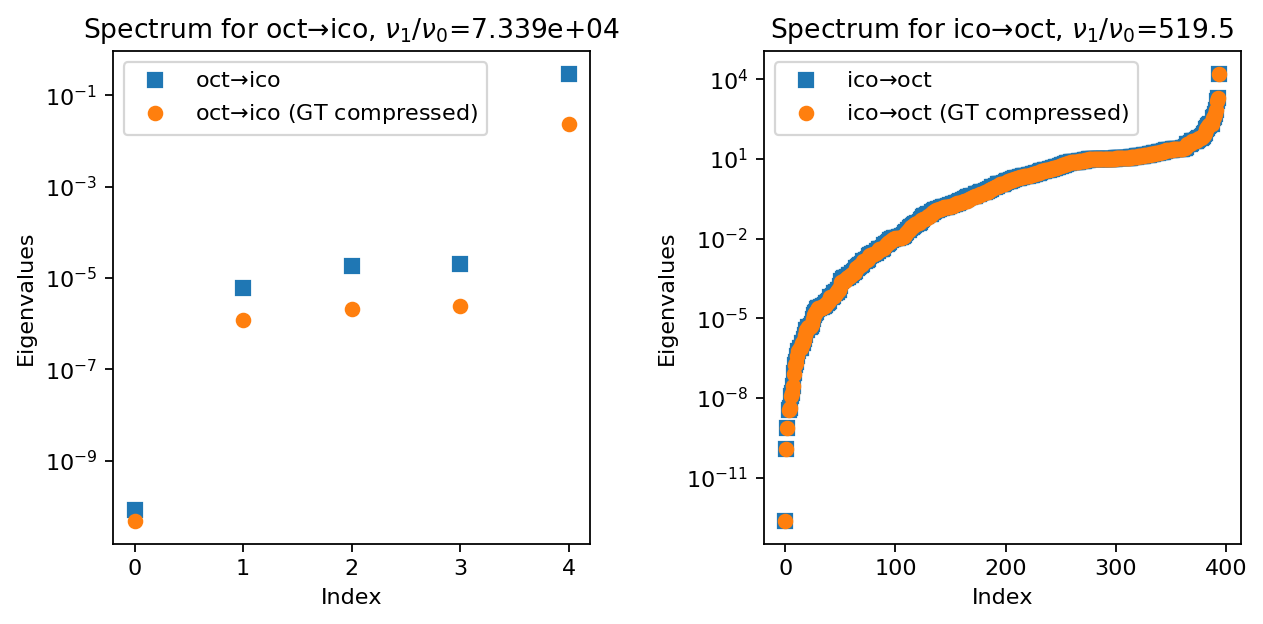

In [109]:
fig,ax = plt.subplots(1,2,figsize=(8,4),dpi=160)

kdata = [] # SS,NSS,QSD,nu

for i, r_s in enumerate([r_A_states,r_B_states]) :
    
    l, v = spla.eig(rK[r_s,:][:,r_s].todense())
    
    qsdo = np.abs(l.real).argsort()
    nu = l.real[qsdo]
    
    rho = np.exp(-r_BF[r_s])
    rho /= rho.sum()
    
    qsd = v[:,qsdo[0]]
    qsd /= qsd.sum()
       
    snu = (rK[r_s,:][:,r_s].dot(qsd)).sum()
    
    C = np.ravel(rB[~r_s,:][:,r_s].sum(axis=0))
    
    
    
    """
       Further GT compression of final states - differences are due to numerical issues
    """    
    rm_reg = np.zeros(rN,bool)   
    rm_reg[(~r_s).nonzero()[0]] = True
    rm_reg[(~r_s).nonzero()[0][r_BF[~r_s].argmin()]] = False
    
    rrB, rrD, rrK, rrN, retry = gt_seq(N=rN,rm_reg=rm_reg,B=rB,D=rD,trmb=1,retK=True,Ndense=1)
    rr_s = r_s[~rm_reg]
    rl, rv = spla.eig(rrK[rr_s,:][:,rr_s].todense())
    rqsdo = np.abs(rl.real).argsort()
    rnu = rl.real[rqsdo]
    
    qsd = rv[:,rqsdo[0]]
    qsd /= qsd.sum()
    
    
    irrK = spla.inv(rrK[rr_s,:][:,rr_s].todense())
    tau = irrK.dot(rho).sum(axis=0)
    T_AB = irrK.sum(axis=0)
    k_F = (rho/T_AB).sum()
    """
        SS, NSS, QSD, nu, 1.K.qsd, kF, 1/tau
    """
    kdata.append([C.dot(np.diag(rDSS[r_s])).dot(rho),C.dot(np.diag(rD[r_s])).dot(rho),C.dot(np.diag(rD[r_s])).dot(qsd),nu[0],snu,k_F,1.0/tau])
    
    

       
    
    ax[i].set_title(r"Spectrum for %s$\to$%s, $\nu_1/\nu_0$=%4.4g" % (names[i],names[1-i],nu[1]/nu[0]))
    ax[i].set_ylabel("Eigenvalues")
    ax[i].set_xlabel("Index")
    ax[i].plot(nu,'s',label=r"%s$\to$%s" % (names[i],names[1-i]))
    ax[i].plot(rnu,'o',label=r"%s$\to$%s (GT compressed)" % (names[i],names[1-i]))
    ax[i].set_yscale("log")
    ax[i].legend()
plt.tight_layout()


# Check for numerical consistency

## We can show analytically that  $\nu_0 \equiv {\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ = "1.K.qsd"

## and also $\nu_0 \equiv {\bf C}^\mathcal{A}_\mathcal{B}\, {\bf D}^\mathcal{I}_\mathcal{B}\, \hat{\pi}^{QSD}_\mathcal{B^I}$    =   "k_qsd"

## I find ${\bf 1}_\mathcal{B}{\bf K}\,\hat{\pi}^{QSD}_\mathcal{B^I}$ is the least reliable

## We also calculate $k^F$ and $k^*=1/\langle\tau\rangle$, but these are not required to equal "kQSD"


In [110]:
for i in range(2):
    print("\n\t %s -> %s" % (names[i],names[1-i]))
    print("\n\t nu_0 = %4.4g, 1.K.qsd = %4.4g. Error = %4.4g%%" % (kdata[i][3],kdata[i][4],(kdata[i][4]/kdata[i][3])*100.0-100.0))
    print("\n\t kSS = %4.4g, kNSS = %4.4g, kQSD = %4.4g\n\n\t kF = %4.4g, k* = %4.4g, Error = %4.4g%% \n\n---------\n" % \
          (kdata[i][0],kdata[i][1],kdata[i][2],kdata[i][5],kdata[i][6],(kdata[i][6]/kdata[i][5])*100.0-100.0))


	 oct -> ico

	 nu_0 = 8.38e-11, 1.K.qsd = 8.38e-11. Error = -6.311e-08%

	 kSS = 2.31e-05, kNSS = 6.423e-11, kQSD = 2.153e-10

	 kF = 4.776e-11, k* = 4.776e-11, Error = -8.971e-09% 

---------


	 ico -> oct

	 nu_0 = 2.31e-13, 1.K.qsd = -4.042e-13. Error = -275%

	 kSS = 3.633e-07, kNSS = 2.736e-07, kQSD = 6.543e-13

	 kF = 2.018e-07, k* = 1.855e-07, Error = -8.048% 

---------

